In [1]:
!pip install -q python-igraph scikit-learn

In [2]:
import torch
from torch.utils.data import Subset
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

# Define the transformation pipeline:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float()),  # Binarize the image
    transforms.Lambda(lambda x: x.view(-1))           # Flatten into a 784-dim vector
])

# Load the training set (set download=True if running for the first time)
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Get indices for images where the label is 1
indices = (mnist_train.targets == 1).nonzero().squeeze()

# Create a subset containing only the '1's
mnist_train_ones = Subset(mnist_train, indices)

print(f"Total number of '1' images in the training set: {len(mnist_train_ones)}")

# Stack all 784-dim vectors from the filtered dataset
all_vectors = torch.stack([img for img, _ in mnist_train_ones])
unique_vectors = torch.unique(all_vectors, dim=0)

print(f"Total images in mnist_train_ones: {all_vectors.shape[0]}")
print(f"Unique images: {unique_vectors.shape[0]}")

if all_vectors.shape[0] == unique_vectors.shape[0]:
    print("All 784-dimensional vectors are unique.")
else:
    print("There are duplicates in the 784-dimensional vectors.")



Total number of '1' images in the training set: 6742
Total images in mnist_train_ones: 6742
Unique images: 6726
There are duplicates in the 784-dimensional vectors.


In [3]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import igraph as ig

def visualize_threshold_graph_igraph(unique_vectors, distance_threshold):
    """
    Builds an unweighted graph with python-igraph where each unique vector is a node
    and an edge is added between nodes if their Euclidean distance is <= distance_threshold.

    Args:
        unique_vectors (torch.Tensor or np.array): Array/tensor of shape (n, 784) containing unique images.
        distance_threshold (float): Maximum Euclidean distance for adding an edge between two nodes.

    Returns:
        g (igraph.Graph): The constructed unweighted graph.
    """
    # Convert tensor to numpy array if necessary.
    if hasattr(unique_vectors, 'numpy'):
        X = unique_vectors.numpy()
    else:
        X = unique_vectors

    n = X.shape[0]
    print(f"Building unweighted graph for {n} nodes...")

    # Use NearestNeighbors to find all pairs within the distance threshold.
    nbrs = NearestNeighbors(radius=distance_threshold, algorithm='auto').fit(X)
    distances, indices = nbrs.radius_neighbors(X)

    # Build list of edges.
    edge_list = []
    for i, neigh in enumerate(indices):
        # For each neighbor j of node i, add edge only if i < j to avoid duplicates.
        for j in neigh:
            if i < j:
                edge_list.append((i, j))

    # Create an undirected graph using python-igraph.
    g = ig.Graph(n=n, edges=edge_list, directed=False)

    print(f"Unweighted graph built with {len(edge_list)} edges.")
    return g

# Example usage:
g = visualize_threshold_graph_igraph(unique_vectors, distance_threshold=6)


Building unweighted graph for 6726 nodes...
Unweighted graph built with 4681902 edges.


In [4]:
# Compute components
components = g.connected_components()
largest_component = g.connected_components().giant()

# Get index of largest component
largest_component_id = components.sizes().index(max(components.sizes()))

# Get node indices of largest component (original graph indices)
largest_component_indices = np.where(np.array(components.membership) == largest_component_id)[0]

# Pick a random node from it
random_node = np.random.choice(largest_component_indices)

# Get its neighbors in the original graph
neighbors = g.neighbors(random_node, mode="all")

# Get vectors
random_vector = unique_vectors[random_node]
neighbor_vectors = unique_vectors[neighbors]

# print("Random vector:", random_vector)
# print("Neighbor vectors:", neighbor_vectors)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


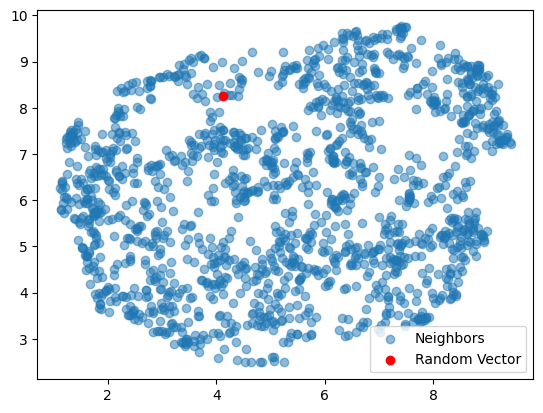

In [15]:
import numpy as np
import umap
import matplotlib.pyplot as plt

# Stack vectors
all_vectors = np.vstack((random_vector, neighbor_vectors))

# Fit UMAP to 2D
reducer = umap.UMAP(n_components=2)
embedding = reducer.fit_transform(all_vectors)

# Plot
plt.scatter(embedding[1:, 0], embedding[1:, 1], alpha=0.5, label='Neighbors')
plt.scatter(embedding[0, 0], embedding[0, 1], color='red', label='Random Vector')
plt.legend()
plt.show()


In [5]:
import numpy as np
from sklearn.decomposition import PCA

# Assuming random_vector and neighbor_vectors are numpy arrays

# Stack into one array
all_vectors = np.vstack((random_vector, neighbor_vectors))

# Do PCA for top 5 components
pca = PCA(n_components=5)
pca.fit(all_vectors)

# Get variance ratios
explained_variance = pca.explained_variance_ratio_

# Output nicely
for i, var in enumerate(explained_variance):
    print(f"PC{i+1} explains {var * 100:.2f}% of variance")


PC1 explains 21.75% of variance
PC2 explains 10.40% of variance
PC3 explains 9.03% of variance
PC4 explains 3.95% of variance
PC5 explains 3.85% of variance


In [6]:
n = g.vcount()
m = g.ecount()

density = 2 * m / (n * (n - 1)) if n > 1 else 0

print("Density:", density)
print("Sparsity:", 1 - density)

Density: 0.2070156425655532
Sparsity: 0.7929843574344468


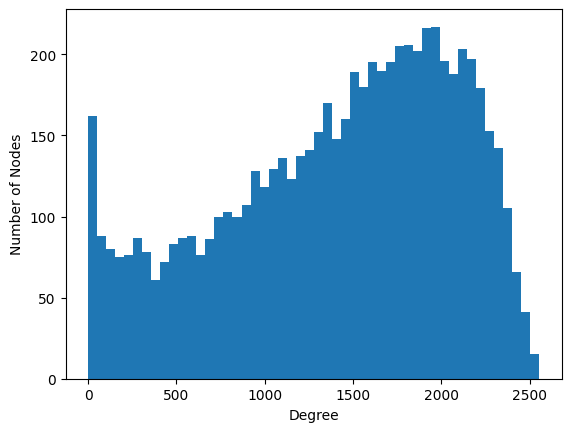

In [7]:
import matplotlib.pyplot as plt

degree = largest_component.degree()
plt.hist(degree, bins=50)
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.show()


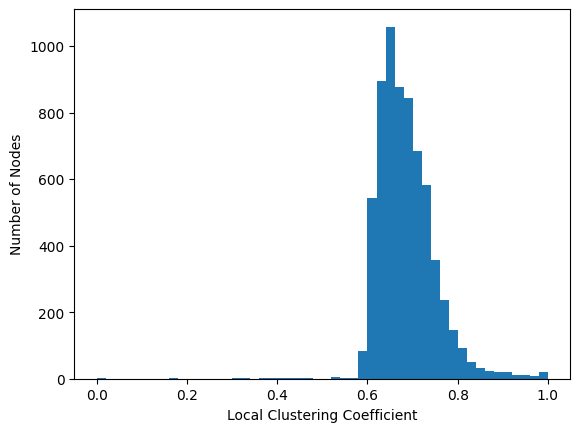

In [8]:
cc = largest_component.transitivity_local_undirected(vertices=None)
plt.hist([c for c in cc if c is not None], bins=50)
plt.xlabel("Local Clustering Coefficient")
plt.ylabel("Number of Nodes")
plt.show()


In [12]:
triangles = largest_component.cliques(min=3, max=3)
print(len(triangles))


KeyboardInterrupt: 